## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

In [2]:
# fetch the file from github
!wget -q https://github.com/lasrado/Auto_Ticket_Classification/raw/main/complaints.zip
# unzip the file into current folder
!unzip /content/complaints.zip

Archive:  /content/complaints.zip
  inflating: complaints.json         


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [3]:
# Opening JSON file 
f = open("/content/complaints.json")
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.
# Look at the first 10 rows
print(df.shape)
df.head(10)


(78313, 22)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0.0,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0.0,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A


In [5]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [6]:
# Check the various type of records by inspecting the values in _type column
print("Values in _type column are:")
df._type.value_counts()

Values in _type column are:


complaint    78313
Name: _type, dtype: int64

In [7]:
# _type column does not add value for this dataset as it contains only complaints.
# id column is a duplicate of complaint_id column.
# score is 0.0 for all records, hence does not add value.
df.drop(["_type", "_score", "_id"], axis=1, inplace=True)
#Assign new column names
df.columns = ['_index', 'tags', 'zip_code',
       'complaint_id', 'issue', 'date_received',
       'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via',
       'date_sent_to_company', 'company_public_response',
       'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue',
       'consumer_consent_provided']

df.head()

,_index,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [8]:
print("Total rows where the complaint text is blank:", df[df.complaint_what_happened == ""].shape[0])
#Assign nan in place of blanks in the complaints column
df.complaint_what_happened = df.complaint_what_happened.replace("", np.nan)

df.shape

Total rows where the complaint text is blank: 57241


(78313, 19)

In [9]:
#Remove all rows where complaints column is nan
df = df[df.complaint_what_happened.isna() == False]
df.shape

(21072, 19)

In [10]:
# Check few value counts of complaints
df.complaint_what_happened.value_counts()

Chase has violated 15 USC 1692 by continuing collection activity after a cease and desist and 15 USC 1681 by failing to report complete and accurate information to credit reporting bureaus.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [11]:
# Write your function here to clean the text and remove all the unnecessary elements.
def text_preprocess(document):
  # Convert the text top lower case
  document = document.lower()
  # Remove the text in the square brackets
  document = re.sub("[\[].*?[\]]", "", document)
  # Remove punctuations from the text
  document = document.translate(str.maketrans('', '', string.punctuation))
  # Remove the words having numbers
  document = document.translate(str.maketrans('','',string.digits))

  return document

In [12]:
# Test text_preprocess function
text_preprocess("3. This is a TEST 123/XX/XX for [all for preprocessing] above function's!")

' this is a test xxxx for  above functions'

In [13]:
# Download the necessary nltk packages
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [14]:
#Write your function to Lemmatize the texts
# define a lemmantizer
wordnet_lemmantizer = WordNetLemmatizer()
def lemmantize(document):
  # Tokenize the text to get words
  words = nltk.tokenize.word_tokenize(document)
  # Remove the stop words
  words = [word for word in words if word not in stopwords.words('english')]
  #Lammetize the words
  words = [wordnet_lemmantizer.lemmatize(word, pos='v') for word in words]
  # Return a concatenated string
  return " ".join(words)

In [15]:
# test the lemmantize function
lemmantize(' this is a testing  for  above functions where training the models')

'test function train model'

In [16]:
# Invoke the lemma function for all rows and insert it as a new column.
df_clean = pd.concat([df.complaint_what_happened, df.complaint_what_happened.apply(lambda x: lemmantize(text_preprocess(x)))], axis=1)
df_clean.head()

,complaint_what_happened,complaint_what_happened
1,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgrade xxxx xxxx card xxxx tell agent upgrade...
10,Chase Card was reported on XX/XX/2019. However...,chase card report xxxx however fraudulent appl...
11,"On XX/XX/2018, while trying to book a XXXX XX...",xxxx try book xxxx xxxx ticket come across off...
14,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...


In [17]:
# Change the column names to be more appropriate.
df_clean.columns = ["complaint", "lemmatized_complaint"]
df_clean.head(10)

,complaint,lemmatized_complaint
1,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgrade xxxx xxxx card xxxx tell agent upgrade...
10,Chase Card was reported on XX/XX/2019. However...,chase card report xxxx however fraudulent appl...
11,"On XX/XX/2018, while trying to book a XXXX XX...",xxxx try book xxxx xxxx ticket come across off...
14,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...
15,Can you please remove inquiry,please remove inquiry
17,With out notice J.P. Morgan Chase restricted m...,notice jp morgan chase restrict account debit ...
20,"During the summer months, I experience a decli...",summer months experience decline income due em...
21,"On XXXX XX/XX/2019, I made a {$300.00} payment...",xxxx xxxx make payment online retailer use cha...
23,I have a Chase credit card which is incorrectl...,chase credit card incorrectly report data cred...


In [18]:
#Write your function to extract the POS tags 
# Load the web simple model
pos_nlp = spacy.load("en_core_web_sm")
def pos_tag(text):
  doc = pos_nlp(text)
  nouns = []
  #Iterate through the tokens in the doc
  for tok in doc:
    # Collect only those where tag == "NN" and "NNP"
    if tok.tag_ == "NN" or tok.tag_ == "NNP":
      nouns.append(tok.text)
  return " ".join(nouns)


# Test the function
pos_tag(df_clean.iloc[1444].lemmatized_complaint)

'chase bank xxxx florida exchange xxxx call x xxxx xxxx'

In [19]:
# Run the pos_tag function on all rows and insert it as a new column.
df_clean["complaint_POS_removed"] =  df_clean.lemmatized_complaint.apply(lambda x: pos_tag(x))
df_clean.head()

,complaint,lemmatized_complaint,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx stop chase bank cardmem...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgrade xxxx xxxx card xxxx tell agent upgrade...,xxxx xxxx card xxxx agent upgrade anniversary ...
10,Chase Card was reported on XX/XX/2019. However...,chase card report xxxx however fraudulent appl...,chase card report xxxx application submit iden...
11,"On XX/XX/2018, while trying to book a XXXX XX...",xxxx try book xxxx xxxx ticket come across off...,xxxx book xxxx xxxx ticket offer ticket apply ...
14,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,grand son check deposit chase account fund cle...


In [20]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head(10)

,complaint,lemmatized_complaint,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx stop chase bank cardmem...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgrade xxxx xxxx card xxxx tell agent upgrade...,xxxx xxxx card xxxx agent upgrade anniversary ...
10,Chase Card was reported on XX/XX/2019. However...,chase card report xxxx however fraudulent appl...,chase card report xxxx application submit iden...
11,"On XX/XX/2018, while trying to book a XXXX XX...",xxxx try book xxxx xxxx ticket come across off...,xxxx book xxxx xxxx ticket offer ticket apply ...
14,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,grand son check deposit chase account fund cle...
15,Can you please remove inquiry,please remove inquiry,inquiry
17,With out notice J.P. Morgan Chase restricted m...,notice jp morgan chase restrict account debit ...,notice jp morgan chase account debit card tues...
20,"During the summer months, I experience a decli...",summer months experience decline income due em...,summer experience income employment month paym...
21,"On XXXX XX/XX/2019, I made a {$300.00} payment...",xxxx xxxx make payment online retailer use cha...,xxxx xxxx payment retailer chase pay xxxx chas...
23,I have a Chase credit card which is incorrectl...,chase credit card incorrectly report data cred...,chase credit card data credit report company i...


In [21]:
#Let us check the shape of the data frame.
df_clean.shape

(21072, 3)

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




Text(0.5, 0, 'Character length ranges')

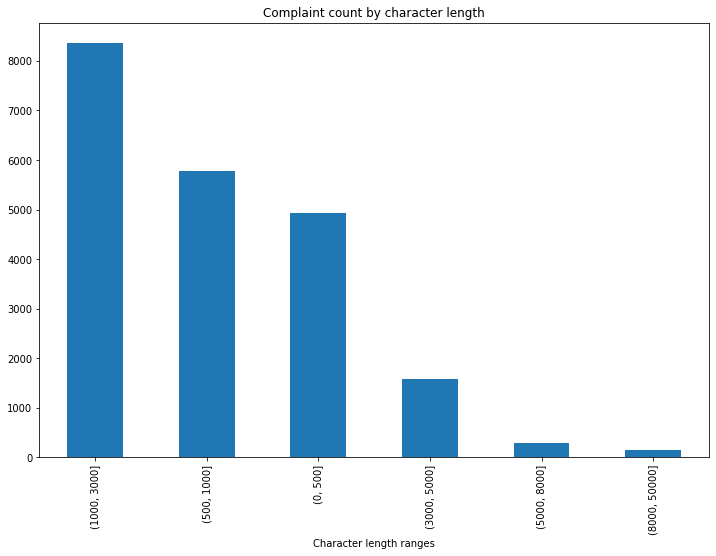

In [22]:
# Build a histogram to visualize the number of charcaters in a complaint. 
bins = [0, 500, 1000, 3000, 5000, 8000, 50000]
temp_df = df_clean.complaint.str.len().to_frame()
temp_df.columns = ["length"]
temp_df['binned'] = pd.cut(temp_df['length'], bins)
temp_df.binned.value_counts()

plt.figure(figsize=(12,8))
temp_df.binned.value_counts().plot(kind="bar")
plt.title("Complaint count by character length")
plt.xlabel("Character length ranges")

By the above histogram, it is evident that most compaints have 0 to 2500 characters.

#### Find the top 40 words by frequency among all the articles after processing the text.

In [23]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Word cloud for lemmatized complaint text

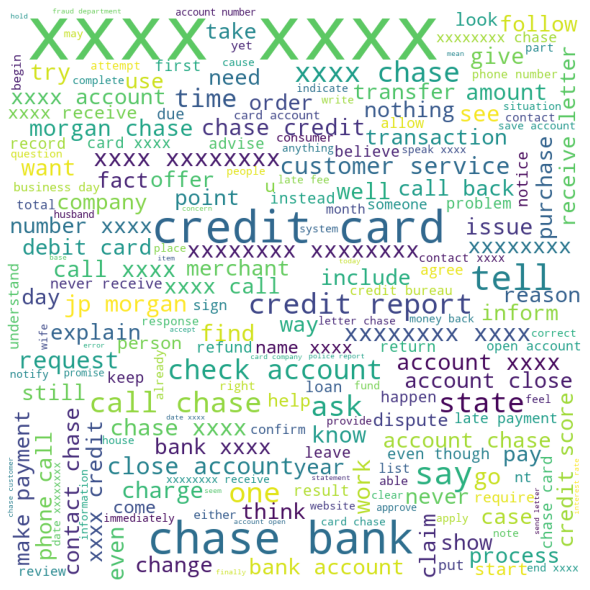

In [24]:
#Word cloud for lemmatized complaint text

lemmatize_complaints = df_clean.lemmatized_complaint.to_list()

lemmaComplaintCloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(" ".join(lemmatize_complaints))
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(lemmaComplaintCloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

### Word cloud for original complaint text

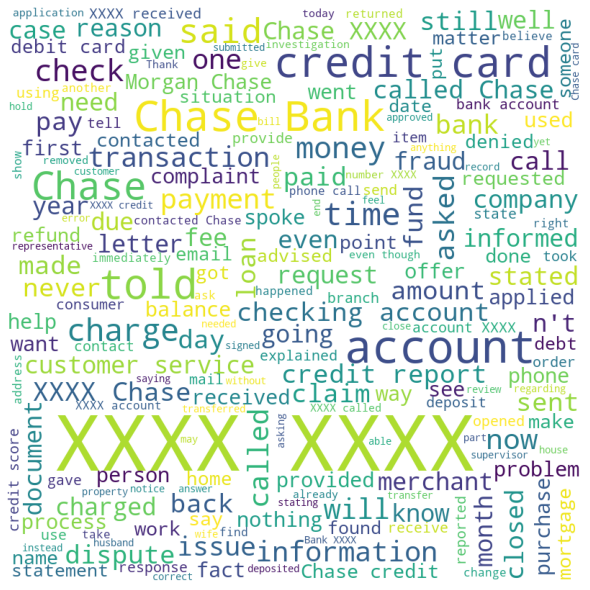

In [25]:
#Word cloud for original complaint text
complaints_list = df_clean.complaint.to_list()

complaintCloud = WordCloud(width = 800, height = 800,
                background_color ='white', min_word_length=3,
                min_font_size = 10).generate(" ".join(complaints_list))
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(complaintCloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

### word cloud for complaints with nouns and propernouns

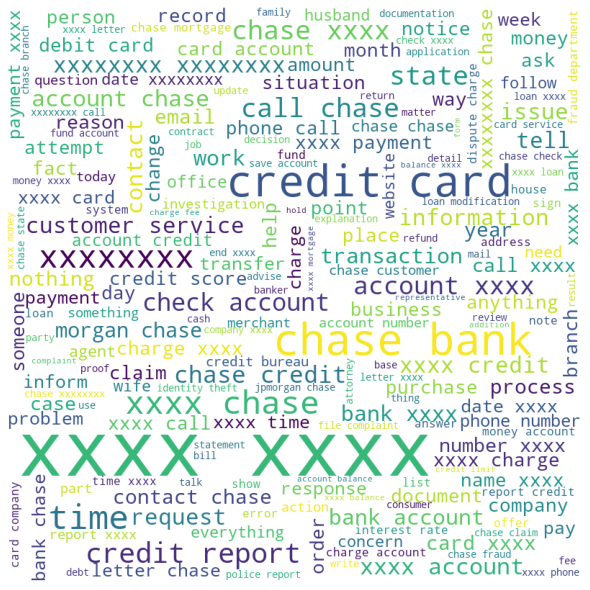

In [26]:
# word cloud for complaints with nouns and propernouns
complaints_pos = df_clean.complaint_POS_removed.to_list()

complaintPosCloud = WordCloud(width = 800, height = 800,
                background_color ='white', min_word_length=3,
                min_font_size = 10).generate(" ".join(complaints_pos))
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(complaintPosCloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [27]:
# words_ dictionary has all the words in sorted order. Get the top 40 keys from the dict.
# Let us use lemmatized complaints for this.
list(lemmaComplaintCloud.words_.keys())[:40]

['xxxx xxxx',
 'chase bank',
 'credit card',
 'tell',
 'say',
 'credit report',
 'call chase',
 'one',
 'state',
 'ask',
 'xxxx chase',
 'check account',
 'time',
 'xxxxxxxx xxxx',
 'request',
 'close account',
 'xxxx xxxxxxxx',
 'customer service',
 'work',
 'jp morgan',
 'chase xxxx',
 'charge',
 'go',
 'find',
 'account xxxx',
 'want',
 'well',
 'issue',
 'amount',
 'call xxxx',
 'morgan chase',
 'know',
 'give',
 'xxxxxxxx xxxxxxxx',
 'even',
 'chase credit',
 'see',
 'try',
 'contact chase',
 'claim']

In [28]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [29]:
df_clean.shape

(21072, 4)

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [30]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
# Function to return top 30 ngram frequencies
def get_ngrams(n=1, count=30):
  # Join all complaints
  complaints_cleaned = " ".join(lemmatize_complaints)
  # Use nltk ngrams util to create desired ngrams
  unigrams = ngrams(complaints_cleaned.split(), n)
  # Get frequency of each ngram
  uni_freq = nltk.FreqDist(unigrams)
  # Sort ngrams dictionary by frequency and return top 30 (default)
  return dict(sorted(uni_freq.items(), key=lambda item: item[1], reverse=True)[:count])

uni_grams = get_ngrams(1)
# Print top 30 unigrams returned
for k, v in uni_grams.items():
  print(k,v)


('xxxx',) 202557
('chase',) 80395
('account',) 48892
('credit',) 34170
('card',) 30522
('bank',) 30050
('xxxxxxxx',) 29273
('call',) 26074
('would',) 20316
('tell',) 19677
('charge',) 18246
('check',) 17878
('receive',) 17759
('make',) 17381
('pay',) 16657
('time',) 16119
('say',) 15716
('get',) 15132
('payment',) 13969
('report',) 13901
('send',) 13105
('go',) 12820
('money',) 11945
('close',) 11547
('back',) 11460
('loan',) 11007
('ask',) 10996
('state',) 10063
('never',) 9946
('letter',) 9680


In [31]:
#Print the top 10 words in the unigram frequency

list(uni_grams.keys())[:10]

[('xxxx',),
 ('chase',),
 ('account',),
 ('credit',),
 ('card',),
 ('bank',),
 ('xxxxxxxx',),
 ('call',),
 ('would',),
 ('tell',)]

In [32]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
bi_grams = get_ngrams(2)
# Print top 30 unigrams returned
for k, v in bi_grams.items():
  print(k,v)

('xxxx', 'xxxx') 84366
('chase', 'bank') 12877
('credit', 'card') 12793
('credit', 'report') 4940
('call', 'chase') 4926
('xxxx', 'chase') 4446
('check', 'account') 4243
('xxxxxxxx', 'xxxx') 3245
('close', 'account') 3174
('xxxx', 'xxxxxxxx') 3090
('customer', 'service') 3057
('jp', 'morgan') 2862
('chase', 'xxxx') 2850
('account', 'xxxx') 2615
('call', 'xxxx') 2502
('morgan', 'chase') 2474
('xxxxxxxx', 'xxxxxxxx') 2464
('chase', 'credit') 2412
('contact', 'chase') 2309
('account', 'chase') 2283
('bank', 'account') 2061
('debit', 'card') 2038
('xxxx', 'account') 2004
('account', 'close') 1977
('call', 'back') 1942
('xxxx', 'call') 1797
('bank', 'xxxx') 1737
('number', 'xxxx') 1735
('receive', 'letter') 1713
('xxxx', 'credit') 1706


In [33]:
#Print the top 10 words in the bigram frequency
list(bi_grams.keys())[:10]

[('xxxx', 'xxxx'),
 ('chase', 'bank'),
 ('credit', 'card'),
 ('credit', 'report'),
 ('call', 'chase'),
 ('xxxx', 'chase'),
 ('check', 'account'),
 ('xxxxxxxx', 'xxxx'),
 ('close', 'account'),
 ('xxxx', 'xxxxxxxx')]

In [34]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
tri_grams = get_ngrams(3)
# Print top 30 unigrams returned
for k, v in tri_grams.items():
  print(k,v)

('xxxx', 'xxxx', 'xxxx') 39510
('jp', 'morgan', 'chase') 2348
('chase', 'credit', 'card') 2076
('xxxx', 'xxxx', 'chase') 1745
('xxxxxxxx', 'xxxx', 'xxxx') 1575
('xxxx', 'xxxx', 'xxxxxxxx') 1345
('chase', 'xxxx', 'xxxx') 1115
('chase', 'bank', 'xxxx') 1048
('xxxx', 'xxxxxxxx', 'xxxx') 969
('credit', 'card', 'account') 956
('credit', 'card', 'company') 953
('call', 'xxxx', 'xxxx') 950
('name', 'xxxx', 'xxxx') 944
('account', 'xxxx', 'xxxx') 901
('bank', 'xxxx', 'xxxx') 884
('xxxx', 'credit', 'card') 864
('xxxx', 'chase', 'bank') 848
('xxxx', 'xxxx', 'account') 753
('xxxx', 'xxxx', 'receive') 694
('credit', 'card', 'chase') 686
('morgan', 'chase', 'bank') 676
('xxxx', 'xxxx', 'call') 663
('xxxxxxxx', 'xxxxxxxx', 'xxxxxxxx') 662
('account', 'chase', 'bank') 631
('call', 'chase', 'bank') 594
('chase', 'customer', 'service') 564
('xxxx', 'xxxx', 'tell') 537
('xxxx', 'xxxx', 'credit') 535
('credit', 'card', 'xxxx') 529
('contact', 'xxxx', 'xxxx') 522


In [35]:
#Print the top 10 words in the trigram frequency
list(tri_grams.keys())[:10]

[('xxxx', 'xxxx', 'xxxx'),
 ('jp', 'morgan', 'chase'),
 ('chase', 'credit', 'card'),
 ('xxxx', 'xxxx', 'chase'),
 ('xxxxxxxx', 'xxxx', 'xxxx'),
 ('xxxx', 'xxxx', 'xxxxxxxx'),
 ('chase', 'xxxx', 'xxxx'),
 ('chase', 'bank', 'xxxx'),
 ('xxxx', 'xxxxxxxx', 'xxxx'),
 ('credit', 'card', 'account')]

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [36]:
# String replace xxxx with empty string
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [37]:
#All masked texts has been removed
df_clean.head(10)

,complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx stop chase bank cardmem...,morning name stop chase bank cardmember serv...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgrade xxxx xxxx card xxxx tell agent upgrade...,xxxx xxxx card xxxx agent upgrade anniversary ...,card agent upgrade anniversary date agent i...
10,Chase Card was reported on XX/XX/2019. However...,chase card report xxxx however fraudulent appl...,chase card report xxxx application submit iden...,chase card report application submit identity...
11,"On XX/XX/2018, while trying to book a XXXX XX...",xxxx try book xxxx xxxx ticket come across off...,xxxx book xxxx xxxx ticket offer ticket apply ...,book ticket offer ticket apply reward card ...
14,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,grand son check deposit chase account fund cle...,grand son check deposit chase account fund cle...
15,Can you please remove inquiry,please remove inquiry,inquiry,inquiry
17,With out notice J.P. Morgan Chase restricted m...,notice jp morgan chase restrict account debit ...,notice jp morgan chase account debit card tues...,notice jp morgan chase account debit card tues...
20,"During the summer months, I experience a decli...",summer months experience decline income due em...,summer experience income employment month paym...,summer experience income employment month paym...
21,"On XXXX XX/XX/2019, I made a {$300.00} payment...",xxxx xxxx make payment online retailer use cha...,xxxx xxxx payment retailer chase pay xxxx chas...,payment retailer chase pay chase website sc...
23,I have a Chase credit card which is incorrectl...,chase credit card incorrectly report data cred...,chase credit card data credit report company i...,chase credit card data credit report company i...


In [38]:
df_clean.shape

(21072, 4)

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [39]:
#Write your code here to initialise the TfidfVectorizer 
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2)


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [40]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfidf_model = vectorizer.fit_transform(list(df_clean.Complaint_clean))
print(tfidf_model)

  (0, 3325)	0.16692221952679942
  (0, 152)	0.255592707932469
  (0, 55)	0.0791579269340278
  (0, 1527)	0.1875654239270798
  (0, 3667)	0.12618820025121438
  (0, 494)	0.1730331028370322
  (0, 4557)	0.1563321787772722
  (0, 4245)	0.15908667822591563
  (0, 435)	0.16459700582172523
  (0, 6719)	0.16952523260228228
  (0, 7570)	0.25119724617349765
  (0, 1850)	0.5538454936623514
  (0, 7840)	0.19725654094330486
  (0, 6382)	0.13076912313633712
  (0, 1009)	0.30583775976836064
  (0, 612)	0.17614125149604445
  (0, 1147)	0.1810967684941842
  (0, 6768)	0.23565087867268444
  (0, 4653)	0.1499617484803759
  (0, 4577)	0.2295329739616954
  (1, 4485)	0.2132463924914393
  (1, 5793)	0.1430341670300961
  (1, 1498)	0.2132463924914393
  (1, 1127)	0.15038549272674953
  (1, 4938)	0.1438414430419058
  :	:
  (21070, 1702)	0.12907931403955272
  (21070, 1127)	0.06819195230175625
  (21070, 1002)	0.24742167247433344
  (21070, 1147)	0.15914075583548726
  (21071, 6279)	0.22671751137871532
  (21071, 5530)	0.1801082250306362

In [41]:
# Vectorise the data
pd.DataFrame(tfidf_model.toarray(), columns=vectorizer.get_feature_names())

,aa,aarp,ab,aba,abandon,abandonment,abatement,abbreviation,abd,aberrant,...,ys,ytd,yup,zap,zelle,zero,zilch,zip,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [42]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [43]:
#Load your nmf_model with the n_components 
# The first try is with 10 tpics.
num_topics = 10

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [44]:
#nmf_model.fit(tfidf_model)
W = nmf_model.fit_transform(tfidf_model)  # Document-topic matrix
H = nmf_model.components_       # Topic-term matrix
len(vectorizer.get_feature_names())

7905

In [45]:
#Print the Top15 words for each of the topics
words = np.array(vectorizer.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,chase,reason,access,save,business,name,activity,balance,branch,open,number,fraud,transfer,identity
Topic 2,card,credit,chase,use,score,limit,point,application,reason,reward,purchase,freedom,amazon,company,bank
Topic 3,loan,mortgage,chase,modification,home,property,foreclosure,house,refinance,morgan,jp,sale,document,time,rate
Topic 4,charge,dispute,merchant,company,amount,fraud,purchase,bill,chase,card,refund,transaction,statement,service,contact
Topic 5,fee,overdraft,charge,refund,time,pay,day,year,service,fund,chase,transaction,waive,customer,bill
Topic 6,report,credit,inquiry,company,debt,jpmcb,information,bureaus,file,score,remove,identity,theft,dispute,date
Topic 7,payment,month,pay,auto,bill,chase,amount,time,date,call,mortgage,statement,error,car,day
Topic 8,check,bank,deposit,money,fund,chase,cash,branch,atm,amount,hold,business,day,debit,tell
Topic 9,balance,interest,rate,transfer,statement,pay,amount,purchase,month,apr,bill,date,rat,owe,advance
Topic 10,chase,call,claim,number,phone,email,letter,information,contact,state,time,fraud,request,service,department


Few topics seem to be duplicates and there is no clear separation between them. Reducing the topics to 5

In [116]:
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)
#nmf_model.fit(tfidf_model)
W = nmf_model.fit_transform(tfidf_model)  # Document-topic matrix
H = nmf_model.components_       # Topic-term matrix

topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,bank,check,chase,money,deposit,fund,branch,call,transfer,business,number,claim,cash,tell
Topic 2,credit,report,card,inquiry,account,score,chase,company,debt,limit,jpmcb,payment,information,balance,bureaus
Topic 3,loan,mortgage,chase,payment,home,modification,time,property,letter,bank,foreclosure,house,document,request,refinance
Topic 4,card,chase,charge,dispute,call,credit,fraud,purchase,claim,merchant,service,email,contact,time,phone
Topic 5,fee,charge,balance,payment,interest,pay,overdraft,statement,bill,month,account,amount,transfer,rate,date


The above topics seem to be disjoint from each other and hence have clear distinction in the words.

In [117]:
df_clean.shape

(21072, 5)

In [118]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_mapping_num = {
    'Topic 1': 0,
    'Topic 2': 1,
    'Topic 3': 2,
    'Topic 4': 3,
    'Topic 5': 4
}

In [120]:
#Assign the best topic to each of the complaints in Topic Column
W = pd.DataFrame(W, columns=[f'Topic {i + 1}' for i in range(num_topics)])
df_clean.reset_index(drop=True, inplace=True)
df_clean['Topic'] = W.apply(lambda x: topic_mapping_num.get(x.idxmax()), axis=1)


In [121]:
df_clean.Topic.value_counts()

3    5779
0    5039
2    4355
1    3731
4    2168
Name: Topic, dtype: int64

In [122]:
df_clean.shape

(21072, 5)

In [123]:
#Print the first 5 Complaint for each of the Topics
df_clean_group=df_clean.groupby('Topic').head(5)
df_clean_group.sort_values('Topic')

,complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx stop chase bank cardmem...,morning name stop chase bank cardmember serv...,0
10,mishandling of this account by Chase auto and ...,mishandle account chase auto xxxx,mishandle account chase auto xxxx,mishandle account chase auto,0
6,With out notice J.P. Morgan Chase restricted m...,notice jp morgan chase restrict account debit ...,notice jp morgan chase account debit card tues...,notice jp morgan chase account debit card tues...,0
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,grand son check deposit chase account fund cle...,grand son check deposit chase account fund cle...,0
12,I opened an account with chase bank on XXXX an...,open account chase bank xxxx use code xxxx bon...,open account chase bank xxxx code xxxx bonus c...,open account chase bank code bonus call foll...,0
5,Can you please remove inquiry,please remove inquiry,inquiry,inquiry,1
2,Chase Card was reported on XX/XX/2019. However...,chase card report xxxx however fraudulent appl...,chase card report xxxx application submit iden...,chase card report application submit identity...,1
9,I have a Chase credit card which is incorrectl...,chase credit card incorrectly report data cred...,chase credit card data credit report company i...,chase credit card data credit report company i...,1
11,I have reached out to XXXX several times in at...,reach xxxx several time attempt fraudulent inq...,time attempt inquiry remove call contact credi...,time attempt inquiry remove call contact credi...,1
3,"On XX/XX/2018, while trying to book a XXXX XX...",xxxx try book xxxx xxxx ticket come across off...,xxxx book xxxx xxxx ticket offer ticket apply ...,book ticket offer ticket apply reward card ...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [124]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    0: 'Bank Account Services',
    1: 'Credit card / Prepaid card',
    2: 'Mortgages/loans',
    3: 'Theft/Dispute reporting',
    4: 'Others'
}



In [125]:
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [126]:
df_clean.head(10)

,complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx stop chase bank cardmem...,morning name stop chase bank cardmember serv...,Bank Account Services
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgrade xxxx xxxx card xxxx tell agent upgrade...,xxxx xxxx card xxxx agent upgrade anniversary ...,card agent upgrade anniversary date agent i...,Theft/Dispute reporting
2,Chase Card was reported on XX/XX/2019. However...,chase card report xxxx however fraudulent appl...,chase card report xxxx application submit iden...,chase card report application submit identity...,Credit card / Prepaid card
3,"On XX/XX/2018, while trying to book a XXXX XX...",xxxx try book xxxx xxxx ticket come across off...,xxxx book xxxx xxxx ticket offer ticket apply ...,book ticket offer ticket apply reward card ...,Credit card / Prepaid card
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,grand son check deposit chase account fund cle...,grand son check deposit chase account fund cle...,Bank Account Services
5,Can you please remove inquiry,please remove inquiry,inquiry,inquiry,Credit card / Prepaid card
6,With out notice J.P. Morgan Chase restricted m...,notice jp morgan chase restrict account debit ...,notice jp morgan chase account debit card tues...,notice jp morgan chase account debit card tues...,Bank Account Services
7,"During the summer months, I experience a decli...",summer months experience decline income due em...,summer experience income employment month paym...,summer experience income employment month paym...,Mortgages/loans
8,"On XXXX XX/XX/2019, I made a {$300.00} payment...",xxxx xxxx make payment online retailer use cha...,xxxx xxxx payment retailer chase pay xxxx chas...,payment retailer chase pay chase website sc...,Theft/Dispute reporting
9,I have a Chase credit card which is incorrectl...,chase credit card incorrectly report data cred...,chase credit card data credit report company i...,chase credit card data credit report company i...,Credit card / Prepaid card


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [127]:
#Create the dictionary again of Topic names and Topics

Topic_name_num = {
    'Bank Account Services': 0,
    'Credit card / Prepaid card': 1,
    'Mortgages/loans': 2,
    'Theft/Dispute reporting': 3,
    'Others': 4
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_name_num)

In [128]:
df_clean.shape

(21072, 5)

In [129]:
df_clean.head(10)

,complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx stop chase bank cardmem...,morning name stop chase bank cardmember serv...,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgrade xxxx xxxx card xxxx tell agent upgrade...,xxxx xxxx card xxxx agent upgrade anniversary ...,card agent upgrade anniversary date agent i...,3
2,Chase Card was reported on XX/XX/2019. However...,chase card report xxxx however fraudulent appl...,chase card report xxxx application submit iden...,chase card report application submit identity...,1
3,"On XX/XX/2018, while trying to book a XXXX XX...",xxxx try book xxxx xxxx ticket come across off...,xxxx book xxxx xxxx ticket offer ticket apply ...,book ticket offer ticket apply reward card ...,1
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,grand son check deposit chase account fund cle...,grand son check deposit chase account fund cle...,0
5,Can you please remove inquiry,please remove inquiry,inquiry,inquiry,1
6,With out notice J.P. Morgan Chase restricted m...,notice jp morgan chase restrict account debit ...,notice jp morgan chase account debit card tues...,notice jp morgan chase account debit card tues...,0
7,"During the summer months, I experience a decli...",summer months experience decline income due em...,summer experience income employment month paym...,summer experience income employment month paym...,2
8,"On XXXX XX/XX/2019, I made a {$300.00} payment...",xxxx xxxx make payment online retailer use cha...,xxxx xxxx payment retailer chase pay xxxx chas...,payment retailer chase pay chase website sc...,3
9,I have a Chase credit card which is incorrectl...,chase credit card incorrectly report data cred...,chase credit card data credit report company i...,chase credit card data credit report company i...,1


In [130]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[['complaint', 'Topic']]

In [131]:
training_data.head()

,complaint,Topic
0,Good morning my name is XXXX XXXX and I apprec...,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,3
2,Chase Card was reported on XX/XX/2019. However...,1
3,"On XX/XX/2018, while trying to book a XXXX XX...",1
4,my grand son give me check for {$1600.00} i de...,0


In [132]:
training_data.Topic.value_counts()

3    5779
0    5039
2    4355
1    3731
4    2168
Name: Topic, dtype: int64

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [133]:

#Write your code to get the Vector count
vectorizer = CountVectorizer(ngram_range=(1,3), stop_words='english', max_df=0.95, min_df=0.02)
vector = vectorizer.fit_transform(training_data.complaint)

print(vector.toarray())



[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [6 0 0 ... 1 1 0]
 [2 0 0 ... 3 1 0]]


In [134]:
#Code to transform the word vector to tf-idf
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer =TfidfTransformer(use_idf=True).fit(vector)
word_vect = tfidf_transformer.transform(vector)
word_vect.shape

(21072, 883)

In [135]:
training_data.shape

(21072, 2)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [136]:
# Write your code here to build any 3 models and evaluate them using the required metrics

# Creating a dataframe of the tf-idf vector for use in model training.
word_vect_df = pd.DataFrame(word_vect.toarray(),columns=vectorizer.get_feature_names(),index=training_data.index)
word_vect_df.head()

,00,00 account,00 chase,00 xx,00 xx xx,00 xxxx,00 xxxx xxxx,10,10 days,100,...,xxxx xxxx credit,xxxx xxxx received,xxxx xxxx told,xxxx xxxx xx,xxxx xxxx xxxx,xxxx years,year,years,years ago,yes
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.160604,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.035616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.068232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [137]:
word_vect_df.shape

(21072, 883)

In [138]:
# Assigning our target variable to the word vector dataframe
word_vect_df["Topic"] = training_data["Topic"]

In [139]:
# Import required libraries for model building
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [140]:
# Build X and y, where y holds the target variable.
X = word_vect_df.drop(["Topic"], axis=1)
y = word_vect_df['Topic']
X.shape

(21072, 883)

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=40, stratify=y)
X_train.shape

(16857, 883)

In [144]:
# define a function to print the metrics. This will help evaluate the model.
def evaluate_model(y_actual,y_pred):
       
    # calculate accuracy
    accuracy = metrics.accuracy_score(y_actual,y_pred)
    
    print("Accuracy:", accuracy)
    print("Recall Score:", metrics.recall_score(y_actual, y_pred, average='macro'))
    print("Precision Score:", metrics.precision_score(y_actual,y_pred, average='macro') )
    print("Classification Report:\n", metrics.classification_report(y_actual, y_pred))
    
    return accuracy

In [145]:
# define a function to predict and get accuracy
def fit_predict_accuracy(model):

  model.fit(X_train, y_train)

  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)
  print("***** Train data report ***********")
  train_accuracy = evaluate_model(y_train.values, y_train_pred)
  print("\n***** Test data report ***********")
  test_accuracy = evaluate_model(y_test.values, y_test_pred)

  return train_accuracy, test_accuracy

# Logistic regression

In [146]:
logisticModel = LogisticRegression(max_iter=1000)


In [147]:
lr_train_accuracy, lr_test_accuracy = fit_predict_accuracy(logisticModel)

***** Train data report ***********
Accuracy: 0.9553301299163552
Recall Score: 0.9478610714336018
Precision Score: 0.9566655734586444
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96      4031
           1       0.96      0.94      0.95      2985
           2       0.96      0.96      0.96      3484
           3       0.95      0.96      0.96      4623
           4       0.96      0.89      0.93      1734

    accuracy                           0.96     16857
   macro avg       0.96      0.95      0.95     16857
weighted avg       0.96      0.96      0.96     16857


***** Test data report ***********
Accuracy: 0.9285883748517201
Recall Score: 0.9193386672891813
Precision Score: 0.9308314587910745
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.95      0.94      1008
           1       0.93      0.92      0.92       746
           2       0.95      0.9

# Decision Trees

In [148]:
dtModel = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=40, class_weight="balanced")
dt_train_accuracy, dt_test_accuracy = fit_predict_accuracy(dtModel)

***** Train data report ***********
Accuracy: 0.6365308180577801
Recall Score: 0.6361978719305309
Precision Score: 0.6568181764839532
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.63      0.65      4031
           1       0.66      0.72      0.69      2985
           2       0.54      0.88      0.67      3484
           3       0.75      0.46      0.57      4623
           4       0.67      0.49      0.57      1734

    accuracy                           0.64     16857
   macro avg       0.66      0.64      0.63     16857
weighted avg       0.66      0.64      0.63     16857


***** Test data report ***********
Accuracy: 0.6422301304863582
Recall Score: 0.6398412015224066
Precision Score: 0.6594549107438985
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.65      0.67      1008
           1       0.66      0.69      0.68       746
           2       0.54      0.8

There should be some scope for improvement in decision trees. Let us try hyper param tuning.

## Hyper param tuning

In [149]:
folds = StratifiedKFold(n_splits=5, shuffle = True, random_state=40)

dt = DecisionTreeClassifier(random_state=40, class_weight="balanced")
params_dt = {
    'max_depth': [5, 10, 20, 40],
    'min_samples_leaf': [5, 10, 20, 50]
}

dt_cv = GridSearchCV(estimator = dt, param_grid = params_dt, scoring = "accuracy",
                           cv=folds, n_jobs=-1, verbose=1, return_train_score=True)

dt_cv.fit(X_train, y_train)

dt_cv_results = pd.DataFrame(dt_cv.cv_results_)
print(dt_cv.best_params_)
dt_cv_results

Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'max_depth': 40, 'min_samples_leaf': 10}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.678983,0.368428,0.029336,0.002594,5,5,"{'max_depth': 5, 'min_samples_leaf': 5}",0.637604,0.618031,0.610798,...,0.627158,0.011509,15,0.637597,0.638636,0.631915,0.639552,0.651268,0.639794,0.006324
1,2.367151,0.017992,0.033018,0.005228,5,10,"{'max_depth': 5, 'min_samples_leaf': 10}",0.637604,0.618031,0.611688,...,0.627929,0.011877,13,0.636856,0.638191,0.632211,0.638736,0.650601,0.639319,0.006091
2,2.142613,0.107943,0.026220,0.002960,5,20,"{'max_depth': 5, 'min_samples_leaf': 20}",0.637307,0.615658,0.611095,...,0.627277,0.012337,14,0.635743,0.635595,0.630876,0.637847,0.650230,0.638058,0.006499
3,1.808799,0.033962,0.024281,0.001412,5,50,"{'max_depth': 5, 'min_samples_leaf': 50}",0.634342,0.612693,0.606942,...,0.624251,0.012347,16,0.631146,0.631813,0.626576,0.635103,0.643111,0.633550,0.005500
4,2.980304,0.089814,0.025054,0.004325,10,5,"{'max_depth': 10, 'min_samples_leaf': 5}",0.731613,0.719454,0.734797,...,0.731210,0.006308,11,0.777605,0.774416,0.789115,0.787854,0.782738,0.782345,0.005686
5,3.372288,0.113380,0.024806,0.001322,10,10,"{'max_depth': 10, 'min_samples_leaf': 10}",0.731020,0.720937,0.734797,...,0.733346,0.007206,9,0.766481,0.761364,0.777992,0.775842,0.770799,0.770496,0.006072
6,3.097220,0.045699,0.028202,0.003351,10,20,"{'max_depth': 10, 'min_samples_leaf': 20}",0.729834,0.719751,0.731237,...,0.731685,0.007357,10,0.758547,0.751057,0.766499,0.765312,0.762420,0.760767,0.005576
7,3.102346,0.233145,0.025950,0.002794,10,50,"{'max_depth': 10, 'min_samples_leaf': 50}",0.720047,0.702550,0.707505,...,0.715727,0.009870,12,0.733704,0.726437,0.733279,0.743957,0.734836,0.734443,0.005598
8,5.321895,0.641745,0.031093,0.010530,20,5,"{'max_depth': 20, 'min_samples_leaf': 5}",0.765421,0.760676,0.760309,...,0.758438,0.005450,6,0.874082,0.873415,0.873721,0.872683,0.875501,0.873880,0.000932
9,7.138792,2.554780,0.029754,0.008035,20,10,"{'max_depth': 20, 'min_samples_leaf': 10}",0.768387,0.766904,0.761792,...,0.764548,0.003501,2,0.839600,0.842640,0.835904,0.836126,0.840131,0.838880,0.002556


The best test score is when {'max_depth': 40, 'min_samples_leaf': 10}, but {'max_depth': 20, 'min_samples_leaf': 10} gives a decent accuracy. Let's go with that to avoid overfitting.

In [150]:
dtModel = DecisionTreeClassifier(max_depth=20, min_samples_leaf=10, random_state=40, class_weight="balanced")
dt_train_accuracy, dt_test_accuracy = fit_predict_accuracy(dtModel)

***** Train data report ***********
Accuracy: 0.8427359553894525
Recall Score: 0.851388533631426
Precision Score: 0.8315506948198786
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86      4031
           1       0.83      0.88      0.85      2985
           2       0.88      0.85      0.87      3484
           3       0.86      0.79      0.82      4623
           4       0.71      0.89      0.79      1734

    accuracy                           0.84     16857
   macro avg       0.83      0.85      0.84     16857
weighted avg       0.85      0.84      0.84     16857


***** Test data report ***********
Accuracy: 0.761803084223013
Recall Score: 0.767771652454525
Precision Score: 0.7502085051397128
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.78      0.79      1008
           1       0.77      0.80      0.78       746
           2       0.82      0.78  

# Random Forest

In [151]:
rfModel = RandomForestClassifier(max_depth=20, min_samples_leaf=10, random_state=40, class_weight="balanced")
rf_train_accuracy, rf_test_accuracy = fit_predict_accuracy(rfModel)

***** Train data report ***********
Accuracy: 0.8982025271400605
Recall Score: 0.9044977654336552
Precision Score: 0.8899405172560855
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.91      4031
           1       0.87      0.93      0.90      2985
           2       0.92      0.92      0.92      3484
           3       0.94      0.84      0.88      4623
           4       0.82      0.92      0.87      1734

    accuracy                           0.90     16857
   macro avg       0.89      0.90      0.90     16857
weighted avg       0.90      0.90      0.90     16857


***** Test data report ***********
Accuracy: 0.8469750889679716
Recall Score: 0.85429516467814
Precision Score: 0.8383425258048167
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.87      1008
           1       0.83      0.88      0.85       746
           2       0.89      0.89 

## Hyper param tuning for RandomForest

In [152]:
folds = StratifiedKFold(n_splits=5, shuffle = True, random_state=40)

rf = RandomForestClassifier(random_state=40, class_weight="balanced")
params_rf = {
    'max_depth': [5, 10, 20, 40],
    'min_samples_leaf': [5, 10, 20, 50]
}

rf_cv = GridSearchCV(estimator = rf, param_grid = params_rf, scoring = "accuracy",
                           cv=folds, n_jobs=-1, verbose=1, return_train_score=True)

rf_cv.fit(X_train, y_train)

rf_cv_results = pd.DataFrame(rf_cv.cv_results_)
print(rf_cv.best_params_)
rf_cv_results

Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'max_depth': 40, 'min_samples_leaf': 5}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,5.779642,0.629884,0.128827,0.006234,5,5,"{'max_depth': 5, 'min_samples_leaf': 5}",0.812871,0.806346,0.802729,...,0.803938,0.007048,16,0.820838,0.815276,0.818553,0.818330,0.809877,0.816575,0.003787
1,4.868482,0.166207,0.106851,0.012619,5,10,"{'max_depth': 5, 'min_samples_leaf': 10}",0.811388,0.808422,0.808069,...,0.804591,0.007695,15,0.818020,0.815944,0.818478,0.817885,0.807504,0.815566,0.004124
2,4.808944,0.150966,0.103724,0.003586,5,20,"{'max_depth': 5, 'min_samples_leaf': 20}",0.812574,0.809905,0.803619,...,0.805303,0.007238,13,0.818539,0.812977,0.815512,0.816180,0.807949,0.814232,0.003607
3,4.801602,0.142504,0.098562,0.005045,5,50,"{'max_depth': 5, 'min_samples_leaf': 50}",0.811684,0.808126,0.805102,...,0.804888,0.005362,14,0.813496,0.810085,0.812101,0.811731,0.804464,0.810376,0.003149
4,8.189624,0.352914,0.155446,0.017529,10,5,"{'max_depth': 10, 'min_samples_leaf': 5}",0.828588,0.837189,0.831504,...,0.831998,0.003547,8,0.868446,0.865258,0.867344,0.869643,0.864600,0.867058,0.001896
5,8.526041,0.305173,0.154549,0.023029,10,10,"{'max_depth': 10, 'min_samples_leaf': 10}",0.835113,0.835113,0.827054,...,0.829803,0.004551,10,0.860586,0.855024,0.856814,0.859113,0.854516,0.857211,0.002333
6,7.756336,0.287516,0.148611,0.015853,10,20,"{'max_depth': 10, 'min_samples_leaf': 20}",0.825623,0.836002,0.827944,...,0.826956,0.005293,11,0.847979,0.845087,0.847768,0.847323,0.846137,0.846859,0.001092
7,7.777439,0.408170,0.164541,0.036710,10,50,"{'max_depth': 10, 'min_samples_leaf': 50}",0.821767,0.822657,0.819341,...,0.819244,0.003038,12,0.833370,0.832925,0.836571,0.837684,0.836126,0.835335,0.001862
8,11.635145,0.554510,0.199461,0.031267,20,5,"{'max_depth': 20, 'min_samples_leaf': 5}",0.855872,0.868624,0.851379,...,0.853888,0.008298,3,0.926363,0.925176,0.925627,0.926220,0.925108,0.925699,0.000518
9,11.809728,0.061881,0.227148,0.035468,20,10,"{'max_depth': 20, 'min_samples_leaf': 10}",0.849348,0.860024,0.845446,...,0.847600,0.006970,4,0.896552,0.896626,0.899377,0.897227,0.897449,0.897446,0.001025


In [153]:
rfModel = RandomForestClassifier(max_depth=20, min_samples_leaf=5, random_state=40, class_weight="balanced")
rf_train_accuracy, rf_test_accuracy = fit_predict_accuracy(rfModel)

***** Train data report ***********
Accuracy: 0.9217535741828321
Recall Score: 0.9266910309068498
Precision Score: 0.9178124259346927
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.93      4031
           1       0.90      0.94      0.92      2985
           2       0.93      0.93      0.93      3484
           3       0.95      0.87      0.91      4623
           4       0.89      0.94      0.92      1734

    accuracy                           0.92     16857
   macro avg       0.92      0.93      0.92     16857
weighted avg       0.92      0.92      0.92     16857


***** Test data report ***********
Accuracy: 0.8502965599051008
Recall Score: 0.8561996842432933
Precision Score: 0.842924768909457
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      1008
           1       0.82      0.88      0.85       746
           2       0.89      0.89

# Multinomial Naive Bayes

In [154]:
from sklearn.naive_bayes import MultinomialNB
nbModel = MultinomialNB()
nb_train_accuracy, nb_test_accuracy = fit_predict_accuracy(nbModel)

***** Train data report ***********
Accuracy: 0.8511597555911491
Recall Score: 0.8250127794239811
Precision Score: 0.8609962343614302
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      4031
           1       0.84      0.82      0.83      2985
           2       0.88      0.90      0.89      3484
           3       0.82      0.88      0.85      4623
           4       0.91      0.63      0.75      1734

    accuracy                           0.85     16857
   macro avg       0.86      0.83      0.84     16857
weighted avg       0.85      0.85      0.85     16857


***** Test data report ***********
Accuracy: 0.8419928825622776
Recall Score: 0.8185096962345064
Precision Score: 0.8549452486708515
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      1008
           1       0.84      0.80      0.82       746
           2       0.86      0.9

In [155]:
# Creating a dataframe to summarise the results of each model.
model_accuracies = pd.DataFrame(
    {"Train Acc": [lr_train_accuracy, dt_train_accuracy, rf_train_accuracy, nb_train_accuracy],
     "Test Acc": [lr_test_accuracy, dt_test_accuracy, rf_test_accuracy, nb_test_accuracy]}, 
      index = ['Logistic Regression','Decision Tree',"Random Forest", "Naive Bayes"])

model_accuracies.head()

,Train Acc,Test Acc
Logistic Regression,0.955330,0.928588
Decision Tree,0.842736,0.761803
Random Forest,0.921754,0.850297
Naive Bayes,0.851160,0.841993


### Logistic Regression is the best performing model with a test accuracy of 93%

In [156]:
import pickle
# Save the LR model for future
pickle.dump(logisticModel, open("logistic_regression_model.h5", "wb"))

# Model Inference

In [157]:
def vectorise_sentence(sentence):
  # Using the same previous vectorizer, Vectorizing the text to apply the model
  complaint_vector = vectorizer.transform(pd.Series(sentence))
  complaint_word_vector = tfidf_transformer.transform(complaint_vector)

  # Convert to a dataframe and return
  return pd.DataFrame(complaint_word_vector.toarray(),columns=vectorizer.get_feature_names())

In [158]:
# A sample complaint # 1 - Topic chosed should be 'Others'
complaint1 = "They charge overdraft fees on authorizations, even though the amount has not been actually captured by the merchant. They take charges from high to low, regardless of order, so if you are overdrawn by $20.00 with 3 transactions for $5 and one for $50, they will always take out the $50 first, leaving you a $26 fee for EACH of the other 3 charges."
topic_predicted = logisticModel.predict(vectorise_sentence(complaint1))
print("This complaint belongs to the topic:", Topic_names[topic_predicted[0]])

This complaint belongs to the topic: Others


In [159]:
# A sample complaint # 2 - Topic chosed should be 'Mortgages or loans'
complaint2 = "Would not recommend a mortgage with you. I was over charged on anual fee for my loan and when asked to clarify, the agent answered rudely."
topic_predicted = logisticModel.predict(vectorise_sentence(complaint2))
print("This complaint belongs to the topic:", Topic_names[topic_predicted[0]])

This complaint belongs to the topic: Mortgages/loans


In [160]:
# A sample complaint # 3 - Topic chosed should be 'Bank Account Services'
complaint3 = "Whenever I go to operate my bank account to withdraw the money, the line is always out to the door and only 2 tellers. Sometimes there are two people on the floor and one teller."
topic_predicted = logisticModel.predict(vectorise_sentence(complaint3))
print("This complaint belongs to the topic:", Topic_names[topic_predicted[0]])

This complaint belongs to the topic: Bank Account Services


## In conclusion, the model is able to accurately predict the topic to which the complaint belongs to.